# Diffusion Validation II

#### This notebbok simulates a diffusion process in a homogenous background magnetic field. The diffusion tensor is anisotropic, meaning the parallel component is larger than the perpendicular component ($\kappa_\parallel = 10\cdot\kappa_\perp$). Additionally, a wind in a perpendicular direction is included.

Load modules and use jupyter inline magic to use interactive plots.

In [18]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare
from scipy.integrate import quad
from scipy.stats import anderson

from crpropa import *

#figure settings
A4heigth = 29.7/2.54
A4width = 21./2.54

Definition of the probability distribution function of the particle density in one dimension: <br>
$\psi(R, t) = \frac{2}{\sqrt{4 \pi D t}} \cdot \exp{-\frac{R^2}{4 D t}}$ <br>
Here, $R=||\vec{R}||$ is the norm of the position.

In [58]:
def gaussian(x, mu=0, sigma=1, N=1):
    
    y = (x-mu)
    two_sSquare = 2*sigma*sigma
    norm = 1./np.sqrt((np.pi*two_sSquare))
    
    return N*norm*np.exp(-y*y/two_sSquare)

Simulation set-up <br>
Using 10000 pseudo particle to trace the phase space.

In [53]:
N = 10000

# magnetic field
ConstMagVec = Vector3d(0,0,1)
BField = UniformMagneticField(ConstMagVec)

# advection field
ConstAdvVec = Vector3d(.3, 0, 0)*meter/second
AdvField = UniformAdvectionField(ConstAdvVec)

# parameters used for field line tracking
precision = 1e-4
minStep = 1e-1*c_light # corresponds to t_min=0.1 s
maxStep = 10*c_light # corresponds to t_max=10 s

#ratio between parallel and perpendicular diffusion coefficient
epsilon = .1

# source settings
# A point source at the origin is isotropically injecting 10TeV protons.
source = Source()
source.add(SourcePosition(Vector3d(0.)))
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourceEnergy(10*TeV))
source.add(SourceIsotropicEmission())

# Output settings
# Only serial number, trajectory length and current position are stored
# The unit of length is set to kpc
Out = TextOutput('./Test2.txt')
Out.disableAll()
#Out.enable(Output.TrajectoryLengthColumn)
Out.enable(Output.CurrentPositionColumn)
#Out.enable(Output.SerialNumberColumn)
Out.setLengthScale(1)

# Difffusion Module
# D_xx=D_yy= 1 m^2 / s, D_zz=10*D_xx
# The normalization is adjusted and the energy dependence is deactivated (setting power law index alpha=0)
Dif = DiffusionSDE(BField, AdvField, precision, minStep, maxStep, epsilon)
Dif.setScale(1./6.1*1e-23)
Dif.setAlpha(0.)


# Boundary
# Simulation ends after t=100kpc/c
# Candidates are recorded on rejection
maxTra = MaximumTrajectoryLength(1000*c_light) # corresponds to t_fin=1000 s
maxTra.onReject(Out)

# module list
# Add modules to the list and run the simulation
sim = ModuleList()

sim.add(Dif)
sim.add(maxTra)

sim.run(source, N, True)

# Close the Output modules to flush last chunk of data to file.
Out.close()


print("Simulation finished")

Simulation finished


Load the simulation data

In [55]:
NAMES = ['X', 'Y', 'Z']
df = pd.read_csv('Test2.txt', delimiter='\t', names=NAMES, comment='#')

#### Anderson Darling Test

Test the three distributions for normality

In [56]:
print ("The test statistic is larger than 1.092 in roughly 1 percent of all cases.")
for c in NAMES:
    print (c, anderson(df[c], 'norm').statistic)

The test statistic is larger than 1.092 in roughly 1 percent of all cases.
X 0.34311526035344286
Y 0.3498507310177956
Z 0.23296336369276105


#### Calculate the mean and variance

Expected values:
 * $\langle x \rangle = 300\,\mathrm{m}$, $\mathrm{Var}(x)=2tD_x=2000\,\mathrm{m^2}$
 
 * $\langle y \rangle = 0$, $\mathrm{Var}(y)=2000\,\mathrm{m^2}$
 
 * $\langle z \rangle = 0$, $\mathrm{Var}(z)=2tD_z=20{,}000\,\mathrm{m^2}$



In [57]:
for c in NAMES:
    print (c, df[c].mean(), df[c].var())

X 299.14420700000005 1982.0227060457557
Y 0.38550313918399987 2009.6828843910548
Z -0.7786564900939995 20309.406758098736


<IPython.core.display.Javascript object>


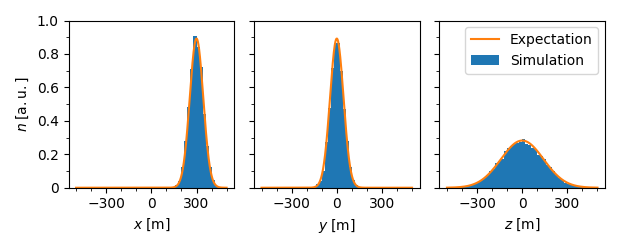

In [59]:
binning=np.linspace(-500, 500, 51)

fig = plt.figure(figsize=(6.2, 2.5))
ax = fig.add_subplot(131)
ax.hist(df.X, bins=binning, histtype='stepfilled', density=10000)
x = np.linspace(-500, 500, 10000)
y = gaussian(x, mu=300, sigma=np.sqrt(2*1000))
ax.plot(x, y)
ax.set_xticks([-300, 0, 300])
ax.set_xticks(np.linspace(-500, 500, 11), minor=True)
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks(np.linspace(0,1e-2, 11), minor=True)
ax.set_ylim(0,1e-2)
ax.set_xlabel(r'$x\;[\mathrm{m}]$')
ax.set_ylabel(r'$n\;[\mathrm{a.u.}]$')

ax2 = fig.add_subplot(132)
ax2.hist(df.Y, bins=binning, histtype='stepfilled', density=10000)
x = np.linspace(-500, 500, 10000)
y = gaussian(x, mu=0, sigma=np.sqrt(2*1000))
ax2.plot(x, y)
ax2.set_xticks([-300, 0, 300])
ax2.set_xticks(np.linspace(-500, 500, 11), minor=True)
ax2.set_yticklabels([])
ax2.set_yticks(np.linspace(0,1e-2, 11), minor=True)
ax2.set_ylim(0,1e-2)
ax2.set_xlabel(r'$y\;[\mathrm{m}]$')

ax3 = fig.add_subplot(133)
ax3.hist(df.Z, bins=binning, histtype='stepfilled', density=1e4, label='Simulation')
x = np.linspace(-500, 500, 10000)
y = gaussian(x, mu=0, sigma=np.sqrt(2*1000*10))
ax3.plot(x, y, label='Expectation')
ax3.set_xticks([-300, 0, 300])
ax3.set_xticks(np.linspace(-500, 500, 11), minor=True)
ax3.set_yticklabels([])
ax3.set_yticks(np.linspace(0,1e-2, 11), minor=True)
ax3.set_ylim(0,1e-2)
ax3.set_xlabel(r'$z\;[\mathrm{m}]$')
plt.legend()

plt.tight_layout()
plt.show()

${\mathrm{\bf Fig 2:}}$ Distribution of pseudo-particle postion at time $t=1000\,\mathrm{s}$ compared to the expected phase space density.